### Requirements

In [1]:
# !pip install -r requirements.txt

In [2]:
!nvidia-smi

Thu Apr 25 19:02:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0              91W / 400W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import os
import sys
sys.path.append("../")

import random
from typing import Tuple, List, Union
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from PIL import Image

import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from transformers import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler, DDIMScheduler
from sklearn.model_selection import train_test_split

In [4]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    # Data
    image_size = 32

    # Model
    model_channels: int = 64

    # Noise Scheduler
    num_train_timesteps = 1_000
    num_inference_steps = 100
    beta_start = 0.0001
    beta_end = 0.02
    beta_schedule = "squaredcos_cap_v2"

    # Training
    batch_size = 16
    epochs = 60
    learning_rate = 1e-4
    lr_warmup_steps = 500

    # Accelerator
    gradient_accumulation_steps = 16
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision

    device = "cuda"
    random_state = 42


config = TrainingConfig()

In [5]:
def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)


seed_everything(config.random_state)

In [6]:
PATH = "/home/jovyan/novitskiy/3d-material-diffusion"
DATA = PATH + "/data/berea_sandstone/"
TRAIN = DATA + "Berea_2d25um_grayscale_filtered.raw"

# Data

In [7]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

In [8]:
from torchvision import transforms


class MaterialsDataset(Dataset):
    def __init__(self, path_to_3d_material: str = "", transforms = None, chunk_size: int = 100):
        super().__init__()

        self.path_to_3d_material = path_to_3d_material
        self.transforms = transforms
        self.chunk_size = chunk_size
        self.material = torch.from_numpy(
            np.fromfile(
                self.path_to_3d_material, dtype='int8', sep=""
            ).reshape(1000, 1000, 1000)
        )
        self.material = self._truncate(self.material)
        self.chunks = self._get_chunks(self.material, self.chunk_size)

    @staticmethod
    def _get_chunks(material, chunk_size):
        chunks = []

        d, h, w = material.shape

        for i in range(d // chunk_size):
            for j in range(h // chunk_size):
                for k in range(h // chunk_size):
                    chunks.append(
                        material[
                            i * chunk_size:(i + 1) * chunk_size,
                            j * chunk_size:(j + 1) * chunk_size,
                            k * chunk_size:(k + 1) * chunk_size,
                        ].unsqueeze(0)
                    )

        chunks = torch.cat(chunks, dim=0)

        return chunks

    @staticmethod
    def _truncate(material, h=1000, w=1000):
        return material[:, :h, :w]

    def __getitem__(self, idx: int):
        chunk = self.chunks[idx]

        if self.transforms:
            chunk = self.transforms(chunk)

        return chunk.unsqueeze(dim=0)

    def __len__(self):
        return self.chunks.shape[0]

In [9]:
import matplotlib.pyplot as plt

data = np.fromfile(TRAIN, dtype='int8', sep="")
data.shape

(1000000000,)

In [10]:
data = data.reshape(1000, 1000, 1000)
data.shape

(1000, 1000, 1000)

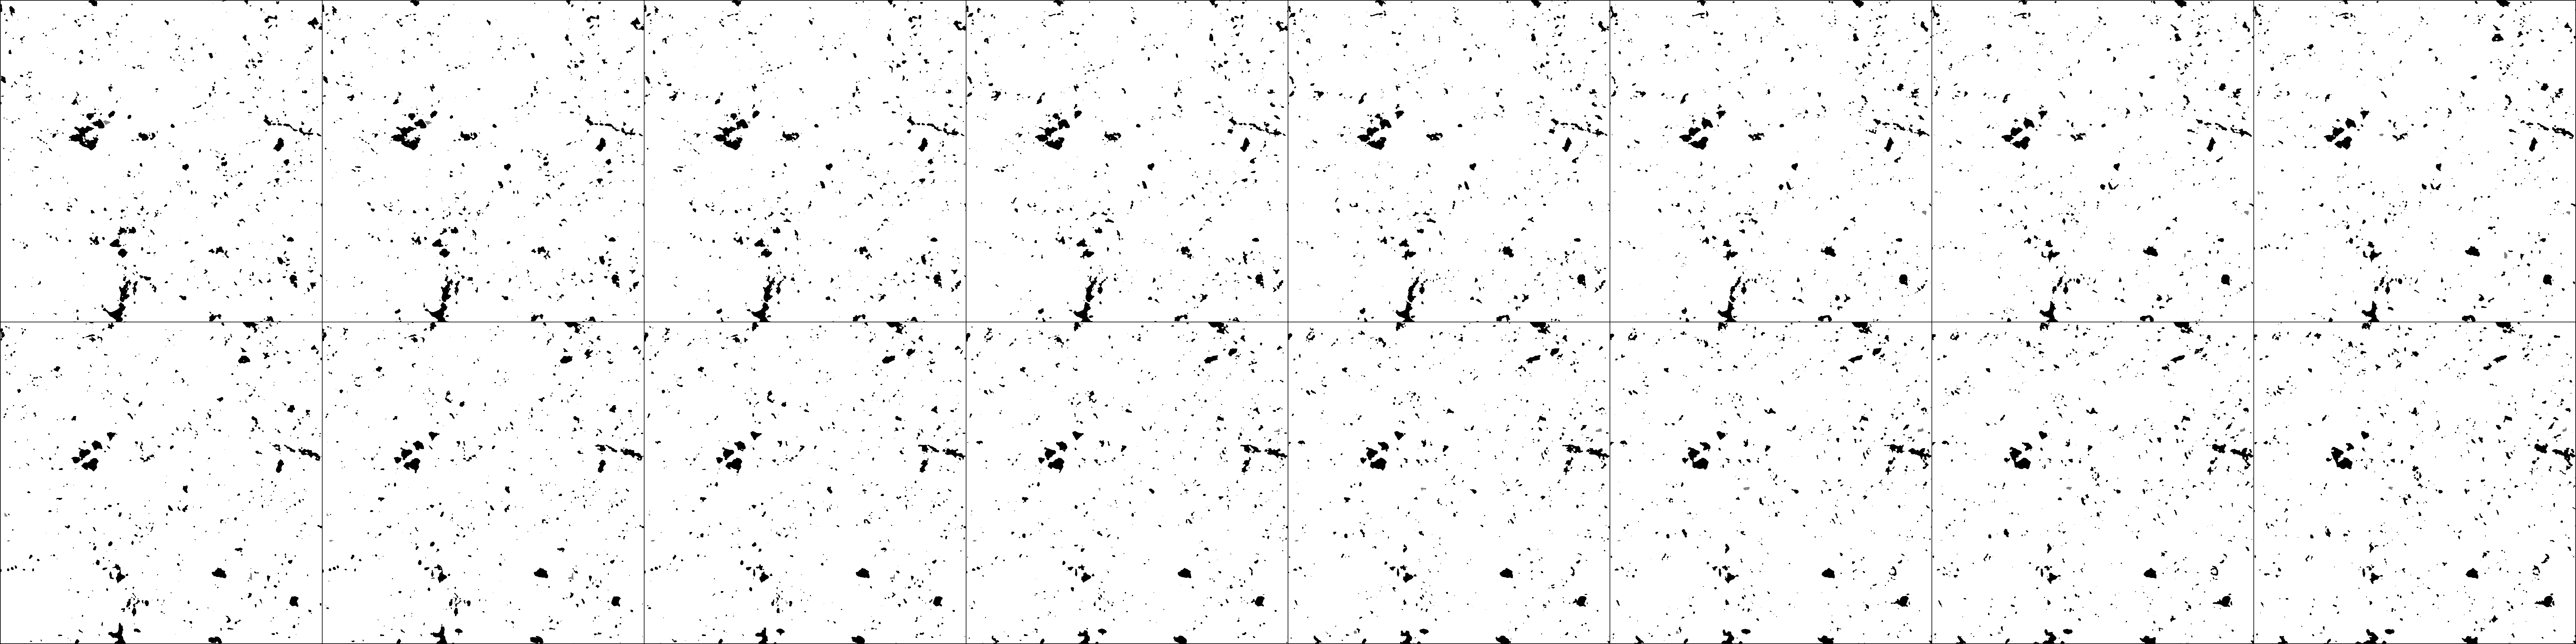

In [11]:
show_images(torch.tensor(data)[:16].unsqueeze(dim=1))

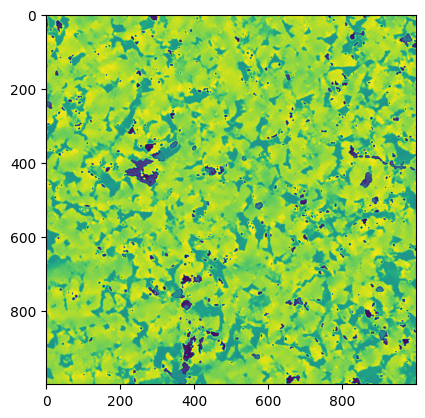

In [12]:
plt.imshow(data[0])

In [13]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Lambda(lambda x: x / 255),
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
])


dataset = MaterialsDataset(
    TRAIN,
    chunk_size=config.image_size,
    transforms=transform,
)

train_inds,  eval_inds = train_test_split(
    [i for i in range(len(dataset))],
    test_size=0.1,
    random_state=config.random_state
    )

train_dataloader = DataLoader(
    Subset(dataset, train_inds),
    batch_size=config.batch_size,
    shuffle=True,
)

eval_dataloader = DataLoader(
    Subset(dataset, eval_inds),
    batch_size=config.batch_size,
    shuffle=False
)

In [14]:
next(iter(eval_dataloader)).shape

torch.Size([16, 1, 32, 32, 32])

### Utils for diffusion processes

In [15]:
def generate(x, model, noise_scheduler, device: str, num_inference_steps: int = 100):
    x, model = x.to(device), model.to(device)
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)
    bs = x.shape[0]
    for i, t in enumerate(noise_scheduler.timesteps):
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(bs,),
            fill_value=t.item(),
            dtype=torch.long
        ).cuda()

        with torch.no_grad():
            noise_pred = model(
                model_input,
                t_batch
            )

        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x

### Training Loop

In [22]:
def train(
    model: torch.nn.Module,
    optimizer,
    scheduler,
    accelerator,
    noise_scheduler,
    loss,
    epochs: int,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader: torch.utils.data.DataLoader,
    device: str,
):
    pbar = range(epochs)
    for epoch in pbar:
        train_losses = []
        eval_losses = []

        #-------------------------------------------------------------#
        # Train epoch
        model.train()
        train_losses_per_epoch = []
        for batch in tqdm(train_dataloader):
            x_1 = batch.to(device)

            bs = x_1.shape[0]
            noise = torch.rand(x_1.shape).to(x_1.device)
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bs,), device=x_1.device
            ).long()

            noisy_x_1 = noise_scheduler.add_noise(x_1, noise, timesteps)

            with accelerator.accumulate(model):
                output = model(
                    noisy_x_1,
                    timesteps
                )

                train_loss = loss(noise, output)
                accelerator.backward(train_loss)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            train_losses.append(train_loss.item() / bs)

        train_dict = {
                        "epoch": epoch + 1,
                        "train_loss": np.mean(train_losses),
                     }

        #-------------------------------------------------------------#
        # Eval epoch
        model.eval()
        eval_losses_per_epoch = []
        for batch in tqdm(eval_dataloader):
            x_1 = batch.to(device)

            bs = x_1.shape[0]
            noise = torch.rand(x_1.shape).to(x_1.device)
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bs,), device=x_1.device
            ).long()

            noisy_x_1 = noise_scheduler.add_noise(x_1, noise, timesteps)


            with torch.no_grad():
                output = model(
                    noisy_x_1,
                    timesteps
                )

                eval_loss = loss(noise, output)

            eval_losses.append(eval_loss.item() / bs)

        eval_dict = {
                        "epoch": epoch + 1,
                        "eval_loss": np.mean(eval_losses),
                     }

        if epoch % 5 == 0:
            torch.save(model, f"checkpoints/baseline/{epoch}.pt",)
        
        x_gen = generate(
            x=torch.randn((1, 1, config.image_size, config.image_size, config.image_size)),
            model=model,
            noise_scheduler=noise_scheduler,
            device=device
        ).cpu()[0][0]
 
        
        train_dict.update(eval_dict)
        train_dict["reconstructed"] = wandb.Image(
            show_images(x_gen[:16].unsqueeze(dim=1))
        )
        wandb.log(
            train_dict
        )
        
        print(train_dict, eval_dict)

In [17]:
def weights_init_xavier(m):
    '''
    Xavier uniform
    '''
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [18]:
!git clone https://github.com/openai/improved-diffusion.git
!python3 ./improved-diffusion/setup.py
sys.path.append("./improved-diffusion/improved_diffusion")
sys.path.append("./improved-diffusion/")

fatal: destination path 'improved-diffusion' already exists and is not an empty directory.
usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: setup.py --help [cmd1 cmd2 ...]
   or: setup.py --help-commands
   or: setup.py cmd --help

error: no commands supplied


In [19]:
from improved_diffusion.unet import UNetModel

model = UNetModel(
    in_channels=1, # should be equal to num_features (input features)
    dims=3, #this states, that we are using 1D U-Net
    model_channels=config.model_channels, # inner model features
    out_channels=1, # should be equal to num_features (input features)
    num_res_blocks=3, # idk
    attention_resolutions=(2, 4, 8) # idk
)

model.apply(weights_init_xavier)

model.to(config.device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

total_steps = int(len(train_dataloader) * config.epochs)
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps = config.lr_warmup_steps, # Default value in run_glue.py
                                    num_training_steps = total_steps)

ddpm_scheduler = DDPMScheduler(
    num_train_timesteps=config.num_train_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule,

)
ddpm_scheduler.set_timesteps(
    num_inference_steps=config.num_inference_steps
)

ddpm_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.02,
  "beta_schedule": "squaredcos_cap_v2",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [20]:
from accelerate import Accelerator

accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
)

train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

In [21]:
!wandb login --relogin 16e2a17c9f21df376f01b89f927dec88e33c2369

wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


In [23]:
import wandb
import random

model_name = "3D Unet Baseline"

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    entity="leffff",
    project="Microstructures",
    name=model_name,
    # track hyperparameters and run metadata
    config=config
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leffff. Use `wandb login --relogin` to force relogin


In [ ]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    accelerator=accelerator,
    noise_scheduler=ddpm_scheduler,
    loss=F.mse_loss,
    epochs=config.epochs,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    device=config.device,
)

  4%|▎         | 62/1676 [00:44<19:06,  1.41it/s]